In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string
import bz2
import nltk
from glob import glob
from tqdm import trange

nltk.download('punkt')

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from functools import partial

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Tesla P100-PCIE-16GB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class WikiDataset(Dataset):

    test_slice = 0.10
    val_slice = 0.20
    inner_sep = '_'
    outer_sep = '|'
    link_cutoff = 50

    def __init__(self, dataset):
        
        self._dataset = dataset

        self.train_ds = self._dataset['train']
        self.val_ds = self._dataset['val']
        self.test_ds = self._dataset['test']

        self._lookup_dict = {'train': self.train_ds, 'val': self.val_ds, 'test': self.test_ds}
        self.set_split('train')

    def train_size(self):
        return len(self.train_ds['source_sentences'])

    def val_size(self):
        return len(self.val_ds['source_sentences'])

    def test_size(self):
        return len(self.test_ds['source_sentences'])

    @classmethod
    def is_a_link(cls, word):
        return len(word) >= 2 and word[0] == cls.outer_sep and word[-1] == cls.outer_sep

    @classmethod
    def pre_process(cls, text, strip_punctuation):
        #punctuation = "{[]()},.;:!?~^'\""
        
        source_sentences = [[token.lower() for token in nltk.word_tokenize(source_sentence)] for source_sentence in text.readlines()]
        valid_links = Counter(token.split(cls.outer_sep)[-2] for source_sentence in source_sentences for token in source_sentence if cls.is_a_link(token))
        valid_links = set(link for link,frequence in Counter(valid_links).items() if frequence >= cls.link_cutoff)
        sentences = []
        labels = []

        for source_sentence in source_sentences:
            sentence = []
            label = []
            has_valid_links = False
            for token in source_sentence:
                if cls.is_a_link(token):
                    _split = list(filter(None, token.split(cls.outer_sep)))
                    if len(_split) == 2:
                        text, link = _split
                        if link in valid_links:
                            link = link.replace("_", " ")
                            has_valid_links = True
                        else:
                            link = None
                        sub_links = filter(None, text.split(cls.inner_sep))
                        for sub_link in sub_links:
                            label.append(link)
                            sentence.append(sub_link)
                    else:
                        token = token.replace(cls.outer_sep, ' ').replace(cls.inner_sep, ' ')
                        label.append(None)
                        sentence.append(token)
                else:
                    label.append(None)
                    sentence.append(token)
            if has_valid_links:
                labels.append(label)
                sentences.append(sentence)
        return sentences, labels

    @classmethod
    def read_dataset(cls, ds_path, strip_punctuation):
        text = bz2.open(ds_path, mode='rt', encoding='utf-8')
        sentences, labels = cls.pre_process(text, strip_punctuation)
        train_size = int(len(sentences) * (1 - cls.test_slice - cls.val_slice))
        test_size = int(len(sentences) * cls.test_slice)
        return {
            'train': {'source_sentences': sentences[:train_size], 'target_labels' : labels[:train_size]},
            'test': {'source_sentences': sentences[train_size:train_size+test_size], 'target_labels' : labels[train_size:train_size+test_size]},
            'val': {'source_sentences' : sentences[train_size+test_size:], 'target_labels' : labels[train_size+test_size:]}
        }
    
    @classmethod
    def load_from_files(cls, ds_dir, max_files=-1, file_ext="bz2", strip_punctuation=False):
        ds_dir = ds_dir + "/" if not ds_dir.endswith("/") else ds_dir
        dumps = glob(ds_dir + "*." + file_ext)
        max_files = len(dumps) if max_files <= -1 else max_files
        ds = {
            'train': {'source_sentences': [], 'target_labels' : []},
            'test': {'source_sentences': [], 'target_labels' : []},
            'val': {'source_sentences': [], 'target_labels' : []}
        }
        for i in range(min(max(1, max_files), len(dumps))):
            path = dumps[i]
            dump = cls.read_dataset(path, strip_punctuation)
            for split in ds.keys():
                ds[split]['source_sentences'] += dump[split]['source_sentences']
                ds[split]['target_labels'] += dump[split]['target_labels']
        return cls(ds)
        

    def reduce(self, dev):
        train_mean = sum([len(x) for x in self.train_ds['source_sentences']]) / self.train_size()
        val_mean = sum([len(x) for x in self.val_ds['source_sentences']]) / self.val_size()
        test_mean = sum([len(x) for x in self.test_ds['source_sentences']]) / self.test_size()

        self.train_ds['source_sentences'] = [x for x in self.train_ds['source_sentences'] if len(x) <= train_mean*dev]
        self.train_ds['target_labels'] = [y for y in self.train_ds['target_labels'] if len(y) <= train_mean*dev]

        self.val_ds['source_sentences'] = [x for x in self.val_ds['source_sentences'] if len(x) <= val_mean*dev]
        self.val_ds['target_labels'] = [y for y in self.val_ds['target_labels'] if len(y) <= val_mean*dev]

        self.test_ds['source_sentences'] = [x for x in self.test_ds['source_sentences'] if len(x) <= test_mean*dev]
        self.test_ds['target_labels'] = [y for y in self.test_ds['target_labels'] if len(y) <= test_mean*dev]

    def encode_from(self, vocabulary):

        for i, sentence in enumerate(self.train_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.train_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.val_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.val_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.test_ds['source_sentences']):
            for j, token in enumerate(sentence):
                self.test_ds['source_sentences'][i][j] = vocabulary.lookup_word(token)

        for i, sentence in enumerate(self.train_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.train_ds['target_labels'][i][j] = vocabulary.lookup_link(token)

        for i, sentence in enumerate(self.val_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.val_ds['target_labels'][i][j] = vocabulary.lookup_link(token)

        for i, sentence in enumerate(self.test_ds['target_labels']):
            for j, token in enumerate(sentence):
                self.test_ds['target_labels'][i][j] = vocabulary.lookup_link(token)


    def set_split(self, split="train"):
        """ Selects the splits in the dataset, from 'train', 'val' or 'test' """
        self._target_split = split
        self._target_ds = self._lookup_dict[split]

    def __len__(self):
        return len(self._target_ds['source_sentences'])

    def __getitem__(self, index):
        sentence = self._target_ds['source_sentences'][index]
        links = self._target_ds['target_labels'][index]
        return {'x_source': sentence, 'y_target': links, 'x_source_length' : len(sentence)}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset"""
        return len(self) // batch_size

In [0]:
class Vocabulary(object):

    _padding_token = '<PAD>'
    _unknown_token = '<UNK>'
    
    def __init__(self, word_to_index, link_to_index):
        self._word_to_index = word_to_index
        self._link_to_index = link_to_index
        self._index_to_word = {i:w for i,w in enumerate(word_to_index)}
        self._index_to_link = {i:l for i,l in enumerate(link_to_index)}

    def source_size(self):
        return len(self._word_to_index)

    def target_size(self):
        return len(self._link_to_index)
    
    def lookup_word(self, word):
        return self._word_to_index.get(word, 1)

    def lookup_link(self, link):
        return self._link_to_index[link]

    def lookup_word_index(self, index):
        return self._index_to_word.get(index, self._unknown_token)

    def lookup_link_index(self, index):
        return self._index_to_link[index]

    @classmethod
    def of(cls, ds):
        source_vocab = dict()
        target_vocab = dict()
        source_vocab = {cls._padding_token : 0, cls._unknown_token : 1}
        target_vocab = {None : 0}

        # Add words to the Vocabulary from the training set only
        for source_sequence in ds.train_ds['source_sentences']:
            for token in source_sequence:
                if token not in source_vocab:
                    source_vocab[token] = len(source_vocab)

        # Add links to the Vocabulary from train, validation and test set. In fact, 
        # this should not influence predictionsbut provides reliability to the model.
        for target_sequence in ds.train_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        for target_sequence in ds.val_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        for target_sequence in ds.test_ds['target_labels']:
            for token in target_sequence:
                if token not in target_vocab:
                    target_vocab[token] = len(target_vocab)

        return cls(source_vocab, target_vocab)

In [0]:
def _vectorize(indices, padding_index, vector_length):
    vector = np.zeros(vector_length, dtype=np.int)
    vector[:len(indices)] = indices
    vector[len(indices):] = padding_index
    return vector.tolist()

def vectorize(input_sequence, padding_index=0, vector_length=-1):
    if vector_length < 0:
        vector_length = input_sequence['x_source_length']

    source_sequence = _vectorize(input_sequence['x_source'], padding_index, vector_length)
    target_sequence = _vectorize(input_sequence['y_target'], padding_index, vector_length)

    return {'x_source' : source_sequence, 'y_target' : target_sequence, 'x_source_length' : input_sequence['x_source_length']}

def collate_fn(batch, device='cpu'):
    batch.sort(key=lambda sample: sample['x_source_length'], reverse=True)
    local_max_length = batch[0]['x_source_length']
    batch = [vectorize(sequence, vector_length=local_max_length) for sequence in batch]
    output_batch = {'x_source' : [], 'y_target' : [], 'x_source_length' : []}
    for sample in batch:
        output_batch['x_source'].append(sample['x_source'])
        output_batch['y_target'].append(sample['y_target'])
        output_batch['x_source_length'].append(sample['x_source_length'])
    return {'x_source' : torch.LongTensor(output_batch['x_source']).to(device), 'y_target' : torch.LongTensor(output_batch['y_target']).to(device), 'x_source_length' : torch.LongTensor(output_batch['x_source_length']).to(device)}

def compute_accuracy(y_hat, y, mask_index=0):
    y_hat = torch.argmax(y_hat, dim=1)
    y = y.view(-1)
    correct_indices = torch.eq(y_hat, y).float()
    valid_indices = torch.ne(y, mask_index).float()
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = max(1, valid_indices.sum().item())
    return n_correct / n_valid * 100

def make_state():
    return {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : [], 'test_loss' : -1, 'test_acc' : -1}

In [0]:
class BiLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, batch_size, num_layers=1, num_directions=2, padding_idx=0, device='cpu'):
        super(BiLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.num_directions = num_directions
        self.device = device

        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_directions, self.target_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_dim).to(self.device), \
        torch.randn(self.num_layers * self.num_directions, self.batch_size, self.hidden_dim).to(self.device))
    
    def forward(self, sequences, lengths):
        # Reset LSTM hidden state, otherwise the LSTM will treat a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        # Dim transformation: (batch_size, seq_size, 1) -> (batch_size, seq_size, embedding_dim)
        embeds = self.word_embedding(sequences)
        embeds = torch.nn.utils.rnn.pack_padded_sequence(embeds, lengths, batch_first=True)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        # Please note that output_lengths are the original 'lengths'
        lstm_out, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        batch_size, seq_size, feat_size = lstm_out.shape

        # Dim transformation: (batch_size, seq_size, hidden_size * directions) -> (batch_size * seq_size, hidden_size * directions)
        lstm_out = lstm_out.contiguous().view(batch_size * seq_size, feat_size)

        link_outputs = self.fc(lstm_out)
        # Output has the shape (batch_size * seq_size, target_size)
        
        return link_outputs

In [6]:
dataset_dir = "drive/My Drive/Wikifier/input_data/"
dataset = WikiDataset.load_from_files(dataset_dir, max_files=6)
dataset.reduce(dev=3)
vocabulary = Vocabulary.of(dataset)
dataset.encode_from(vocabulary)
vocabulary.target_size() #14541 with link cutoff=20

7015

In [7]:
embedding_dim = 128
epochs = 10
hidden_dim = 128
batch_size = 64
device = 'cuda'
learning_rate = 0.001
weight_decay = 0.0001

if not torch.cuda.is_available():
    print("Running model using CPU")
    device = 'cpu'

model = BiLSTM(vocab_size=vocabulary.source_size(), embedding_dim=embedding_dim, hidden_dim=hidden_dim, target_size=vocabulary.target_size(), 
batch_size=batch_size, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=0)
state = make_state()

for epoch in range(epochs): 

    # Training

    dataset.set_split('train')
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=partial(collate_fn, device=device))
    batch_generator = iter(dataloader)

    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for batch_index in trange(len(batch_generator), leave=True, desc="Train progress"):
        batch = batch_generator.next()

        optimizer.zero_grad()

        x, y, x_len = batch.values()
        y_hat = model(x, x_len)

        loss = criterion(y_hat, y.view(-1))
        loss.backward()

        optimizer.step()

        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        acc_t = compute_accuracy(y_hat, y)
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    state['train_loss'].append(running_loss)
    state['train_acc'].append(running_acc)

    # Validation

    dataset.set_split('val')
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=partial(collate_fn, device=device))
    batch_generator = iter(dataloader)

    running_loss = 0.0
    running_acc = 0.0
    model.eval()

    for batch_index in trange(len(batch_generator), leave=True, desc="Validation progress"):
        batch = batch_generator.next()

        x, y, x_len = batch.values()
        y_hat = model(x, x_len)

        loss = criterion(y_hat, y.view(-1))

        running_loss += (loss.item() - running_loss) / (batch_index + 1)
        acc_t = compute_accuracy(y_hat, y)
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    state['val_loss'].append(running_loss)
    state['val_acc'].append(running_acc)

Train progress:  99%|█████████▊| 27256/27646 [24:59<00:22, 17.60it/s]

Buffered data was truncated after reaching the output size limit.

In [8]:
dataset.set_split('test')
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=partial(collate_fn, device=device))
batch_generator = iter(dataloader)

running_loss = 0.0
running_acc = 0.0
model.eval()

for batch_index in trange(len(batch_generator), leave=True, desc="Test"):
    batch = batch_generator.next()

    x, y, x_len = batch.values()
    y_hat = model(x, x_len)

    loss = criterion(y_hat, y.view(-1))

    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_hat, y)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

state['test_loss'] = running_loss
state['test_acc'] = running_acc

Test: 100%|██████████| 3953/3953 [00:54<00:00, 73.06it/s]


In [9]:
state

{'test_acc': 89.33474319612498,
 'test_loss': 0.7500650471007126,
 'train_acc': [87.85639982075257,
  90.45119433657602,
  90.59627905634517,
  90.6792216996826,
  90.74119727403985,
  90.78112161333688,
  90.80898165960768,
  90.86018766210226,
  90.88242211951912,
  90.91102481444054],
 'train_loss': [0.8777057016392948,
  0.6477507127489734,
  0.6384934378506336,
  0.6333547133014765,
  0.6292103167599332,
  0.6261503511209306,
  0.6246275769917581,
  0.6228990970981366,
  0.6209889896629546,
  0.619471410246423],
 'val_acc': [89.40356128764472,
  89.5949598143489,
  89.44782900539663,
  89.66039125774996,
  89.89953301269888,
  89.78301351445836,
  89.63111119922593,
  89.79967240759814,
  89.80513978225274,
  89.9189277151531],
 'val_loss': [0.7287319519615185,
  0.7152131311364343,
  0.7162914515703677,
  0.7057213340964343,
  0.6917657017583321,
  0.7046119397309678,
  0.6981132699124556,
  0.705640138734941,
  0.6985224953730297,
  0.6958431250793405]}

In [10]:
#for k in state.items():
    #print(k)
dataset.set_split('test')
y = 5248
print('x  :  ',[vocabulary.lookup_word_index(k) for k in dataset[y]['x_source']])
print('_y  : ', [vocabulary.lookup_link_index(k) for k in dataset[y]['y_target']])
print('y  :  ', [vocabulary.lookup_link_index(k) for k in dataset[y]['y_target'] if vocabulary.lookup_link_index(k) is not None])
indexes = [k for k in range(len(dataset[y]['y_target'])) if vocabulary.lookup_link_index(dataset[y]['y_target'][k]) != None]
'''
x = "A preacher is a person who delivers sermons or homilies on religious topics to an assembly of people .".lower()
_l = len(x.split())
x = [vocabulary.lookup_word(token) for token in x.split()]
'''
x = dataset[y]['x_source']
_l = len(x)
x = torch.LongTensor([_vectorize(x, 0, _l) for _ in range(batch_size)]).to(device)
l = torch.LongTensor([_l for _ in range(batch_size)]).to(device)
y_hat = model(x, l)
y_hat = y_hat.view(batch_size, _l, -1)
y_hat = torch.argmax(y_hat, dim=2)[0]
y_hat = y_hat.tolist()
p = [vocabulary.lookup_link_index(token) for token in y_hat]
print('y^ :  ',[p[i] for i in indexes])
#print(vocabulary.lookup_link('artificial intelligence'))
print('links:', p)
#'''

x  :   ['it', 'was', 'a', 'commercial', 'success', 'in', 'ronsons', 'native', 'united', 'kingdom', ',', 'where', 'it', 'reached', 'number', 'two', 'on', 'the', 'uk', 'singles', 'chart', '.']
_y  :  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'uk singles chart', 'uk singles chart', 'uk singles chart', None]
y  :   ['uk singles chart', 'uk singles chart', 'uk singles chart']
y^ :   ['uk singles chart', 'uk singles chart', 'uk singles chart']
links: ['information technology', 'assassination', 'a', 'play', 'play', 'south by southwest', 'new york city', 'indigenous peoples of the americas', 'united kingdom', 'united kingdom', 'owned and operated station', 'cover version', 'information technology', 'cover version', 'uk singles chart', 'top 40', 'cover version', 'uk singles chart', 'uk singles chart', 'uk singles chart', 'uk singles chart', 'uk singles chart']


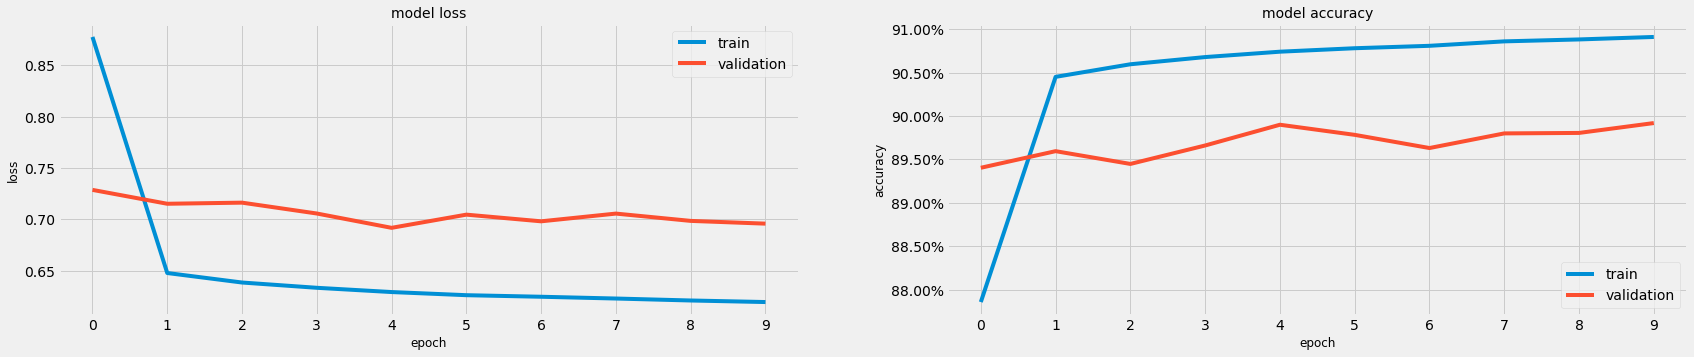

In [26]:

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["figure.figsize"] = (26,5)
plt.style.use('fivethirtyeight')

loss_plot = plt.subplot(121)
loss_plot.set_xticks(np.arange(0, epochs, 1.0))
plt.title('model loss', fontsize=14)
plt.plot(state['train_loss'], label='train')
plt.plot(state['val_loss'], label='validation')
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend()

accuracy_plt = plt.subplot(122)
accuracy_plt.yaxis.set_major_formatter(mtick.PercentFormatter())
accuracy_plt.set_xticks(np.arange(0, epochs, 1.0))
plt.title('model accuracy', fontsize=14)
plt.plot(state['train_acc'], label='train')
plt.plot(state['val_acc'], label='validation')
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend()

plt.show()
plt.close()

embedding_dim = 128
epochs = 10
hidden_dim = 128
batch_size = 64
device = 'cuda'
learning_rate = 0.001
weight_decay = 0.0001
link_cutoff = 50
->   no. of batches = 27646
     input_sentences_validated = 27646 * 64 = 1769344
     time per epoch approx. 26min; approx 18.5 batches per sec
     estimated time for training: 4h 20min